In [23]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

In [3]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}


def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

<Container object of 5 artists>

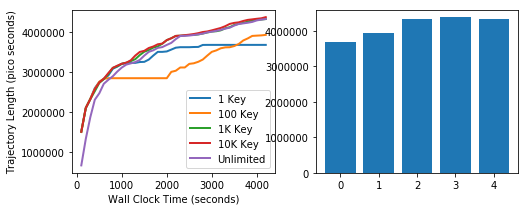

In [22]:
d = "../experiments/baseline-trinitite/"
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
    
def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plot_times(ax[0], "1 Key", d+"nano/purge-keys-working/scale-cachelimit-1-71157")
plot_times(ax[0], "100 Key", d+"nano/purge-keys-working/scale-cachelimit-100-71158")
plot_times(ax[0], "1K Key", d+"nano/purge-keys-working/scale-cachelimit-1000-71159")
plot_times(ax[0], "10K Key", d+"nano/purge-keys-working/scale-cachelimit-10000-71160")
plot_times(ax[0], "Unlimited", d+"nano/sepminima/scale-workers-4-71036")

trajs = []

for run in [d+"nano/purge-keys-working/scale-cachelimit-1-71157",
            d+"nano/purge-keys-working/scale-cachelimit-100-71158",
            d+"nano/purge-keys-working/scale-cachelimit-1000-71159",
            d+"nano/purge-keys-working/scale-cachelimit-10000-71160",
            d+"nano/sepminima/scale-workers-4-71036"]:
    df = get_max_traj(run)
    trajs.append(df['traj'])
ax[1].bar(range(0, len(trajs)), trajs)

In [12]:
def plot_keyspace(ax, op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    label = os.path.basename(results).split('-')[2] + " Keys"
    if label == "4 Keys": label = "Unlimited"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend()

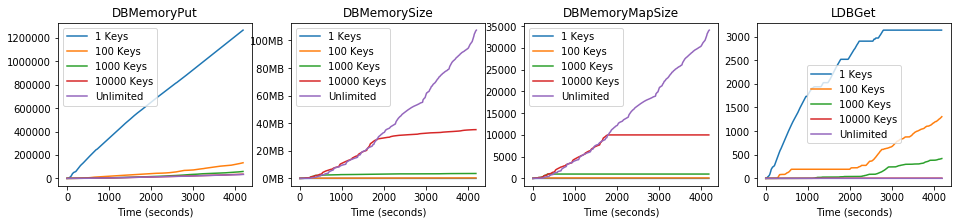

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
d = "../experiments/baseline-trinitite/"
for run in ["nano/purge-keys-working/scale-cachelimit-1-71157",
            "nano/purge-keys-working/scale-cachelimit-100-71158",
            "nano/purge-keys-working/scale-cachelimit-1000-71159",
            "nano/purge-keys-working/scale-cachelimit-10000-71160",
            "nano/sepminima/scale-workers-4-71036"]:
    plot_keyspace(ax[0], "DBMemoryPut", d+run)
    plot_keyspace(ax[1], "DBMemorySize", d+run)
    plot_keyspace(ax[2], "DBMemoryMapSize", d+run)
    plot_keyspace(ax[3], "LDBGet", d+run, rank="2")

ax[1].set_yticklabels(['{:3.0f}MB'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
